## Автоматическое дифференциирование в библиотеке JAX

### Что такое JAX?

`Google JAX` ещё один `python` фреймворк для машинного обучения и оптимизации, позволяющий писать высокоэффективный код с использованием `GPU/TPU` с помощью [`XLA`](https://www.tensorflow.org/xla) (Accelerated Linear Algebra -- это предметно-ориентированный компилятор линейной алгебры). В фреймоврке реализован свой `autodiff`, а так же полезные возможности `compilation` и `parallelization`, о которых мы поговорим несколько позже.

Во многих случаях `API` фреймворка `JAX` совпадает с `API` фреймоврка `numpy`, поэтому чаще всего `JAX` импортируют в код через `import jax.numpy as np` (то есть с той же кличкой как и у `numpy`).

### TL;DR

Пример нахождения градиентов, якобианов и гессианов:

1. Импортировать `jax.numpy`, чтобы записывать функции на понятном для `jax` языке

In [ ]:
import jax
import numpy as np
import jax.numpy as jnp


def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)


def f_vec(x: np.ndarray):
    """
    R^n -> R^n
    """
    return jnp.sin(x)

2. Чтобы получить градиент функции нужно воспользоваться `jax.grad()`

In [ ]:
grad_f2 = jax.grad(f2_float)
print(f"grad at x = 0, y = 0: {grad_f2(np.array([0., 0.]))}")

grad at x = 0, y = 0: [0. 0.]


3. Чтобы получить якобиан нужно использовать либо `jax.jacfwd`, либо `jax.jacrev` (на функциях вида R^n -> R совпадает с градиентом).

In [ ]:
jacf_f2 = jax.jacfwd(f2_float)
jacb_f2 = jax.jacrev(f2_float)
print(f"Jacobian forward pass at x = 0, y = 0: {jacf_f2(np.array([0., 0.]))}")
print(f"Jacobian backward pass at x = 0, y = 0: {jacb_f2(np.array([0., 0.]))}")

Jacobian forward pass at x = 0, y = 0: [0. 0.]
Jacobian backward pass at x = 0, y = 0: [0. 0.]


In [ ]:
jac_f_vec = jax.jacfwd(f_vec)
print(f"Jacobian forward pass at x = 0, y = 0:\n{jac_f_vec(np.array([0., 0.]))}")

Jacobian forward pass at x = 0, y = 0:
[[1. 0.]
 [0. 1.]]


4. Чтобы получить Гессиан достаточно последовательно применить вычисление якобиана.

In [ ]:
hesse_f_f2 = jax.jacfwd(jax.jacfwd(f2_float))
print(f"Hesse at x = 0, y = 0:\n{hesse_f_f2(np.array([0., 0.]))}")

Hesse at x = 0, y = 0:
[[2. 0.]
 [0. 0.]]


### Почему `JAX`?

1. Скорость:


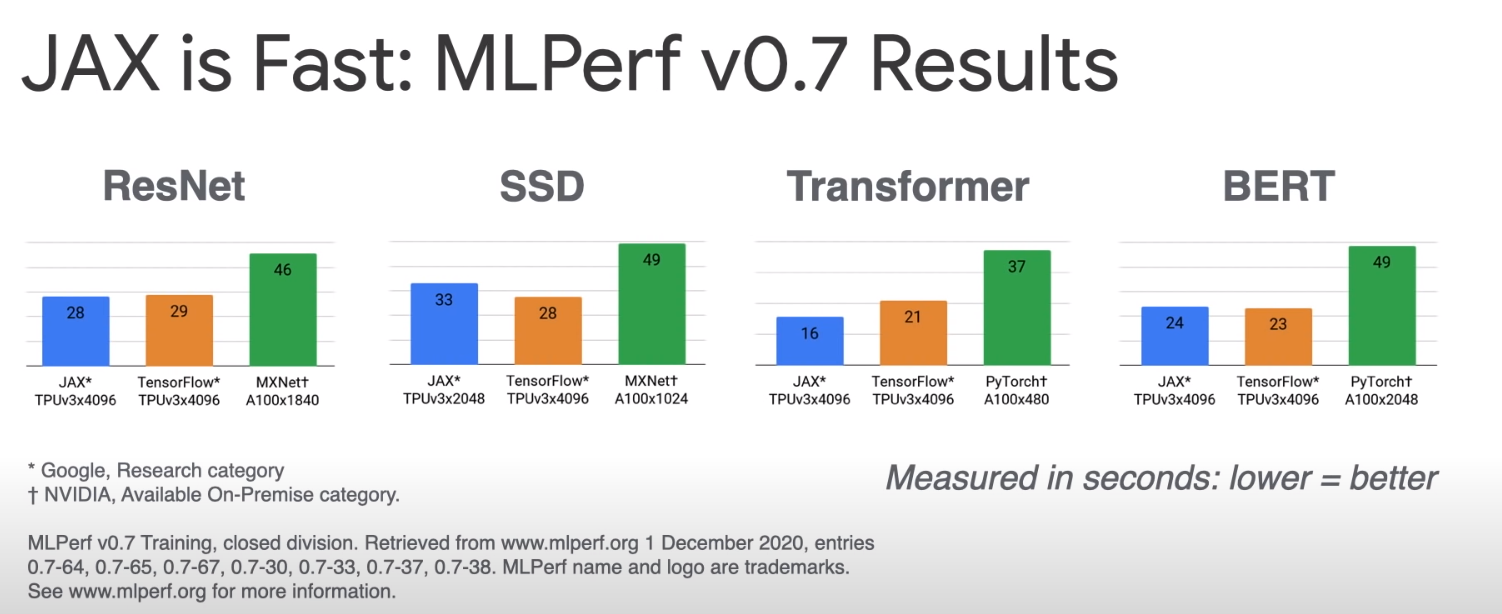

Картинка взята из [видео](https://www.youtube.com/watch?v=WdTeDXsOSj4&t=1s)

2. Схожесть `API` с `Numpy` и `Scipy`.

3. Возможность использовать `autodiff` с помощью функции `grad`.

4. Возможность векторизовать код с помощью функции `vmap` (чтобы работать без циклов).

5. Возможность компилировать часть кода с помощью функции `jit` (just-in-time compilation), что очень сильно ускоряет их работу.

6. Возможность параллелизации кода с помощью функции `pmap`, которая позволяет задействовать несколько ядер вычислительной системы.

7. `JAX` включает в себя
    - Высокоуровневые библиотеки для глубокого обучения: `Flax, Haiku, Trax`
    - библиотеки для оптимизации: `JAXOpt, Optax`
    - библиотеки для [вероятностного программирования](https://habr.com/en/articles/244625/): `Oryx, TFP-jax, NumPyro`
    - библиотеки для работы с [графовыми нейронными сетями](https://habr.com/en/companies/vk/articles/557280/): `Jraph`
    - И многое другое...


### Как `JAX` это делает?

Не углубляясь в детали, можно сказать, что `JAX` отслеживает каждую функцию, которую написал разработчик, переписывает её в свой удобный вид, засчёт которого сразу может использовать `autodiff, vmap, pmap, jit`.

### Код

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams["figure.figsize"] = 11, 7
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 16

In [ ]:
# Проверим платформу на которой будут производиться вычисления
from jax.lib import xla_bridge

print(f"Current computation platform is {xla_bridge.get_backend().platform}")
# JAX will preallocate 75% of the total GPU memory when the first JAX operation is run.

Current computation platform is gpu


In [ ]:
# По умолчанию все вычисления производятся в float32
# Но это можно изменить

jax.config.update("jax_enable_x64", True)

#### `Just-In-Time`

Пару слов о `jit`: `jit` отслеживает, что происходит в каждой функции, прекомпилирует их и кэширует их использование. Если мы вызовем `jit`-функцию, а в следующий раз вызовем её повторно со *схожими* входными данными, то вызываться будет уже кэшированная функциия. Под "*схожими*" понимаются, например, те входные данные, у которых одинаковые размерности (в смысле линейной алгебры). Подробнее об этом можно прочитать тут: [jax.jit](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)

#### Пример

In [ ]:
def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)

In [ ]:
def f2_vec(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp( x / 5)

In [ ]:
f2_float_jitted = jax.jit(f2_float)
print(f"jitted at x = 0, y = 0: {f2_float_jitted(np.array([0., 0.]))}")

jitted at x = 0, y = 0: 0.0


Так же можно использовать **декораторы**:

In [ ]:
@jax.jit
def f2_float(x: np.ndarray) -> float:
    """
    R^n -> R
    """
    return jnp.sin(x[0] ** 2) * jnp.exp(-x.T @ x / 5)


print(f"jitted at x = 0, y = 0: {f2_float(np.array([0., 0.]))}")

jitted at x = 0, y = 0: 0.0


##### Какие функции могут быть обработаны `jit`?

Важно, понимать, что не все функции могут быть обработаны `jit`, так, например, следующий код вызовет ошибку:

In [ ]:
@jax.jit
def non_jitable(x):
    return x[x > 0]


try:
    non_jitable(np.array([-1, 2, -3]))
except Exception as e:
    print(e)

Array boolean indices must be concrete; got ShapedArray(bool[3])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError


Более того, `jit` не будет отслеживать *side-effects* в функциях, например функции `print('hi')` и `global_list.append('hi')` будут игнорироваться при компиляции, поэтому при запуске с `jit` эффекта не будет:

In [ ]:
global_list = []


def impure_func(x):
    print("hi")
    ln_x = jnp.log(x)
    global_list.append("hi")
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2


x = np.array([1, 2, 3])

print("==No jit==")
impure_func(x)
print(global_list)

print("==jit first run==")
# Non cached run
# On this step jit traces the function
impure_func_jited = jax.jit(impure_func)
impure_func_jited(x)
print(global_list)

print("==jit second run==")
# Cached run
impure_func_jited(x)
print(global_list)

print("==jit third run==")
# Getting traced again (x is of len 4)
x = np.array([1, 2, 3, 4])
impure_func_jited(x)
print(global_list)

==No jit==
hi
['hi']
==jit first run==
hi
['hi', 'hi']
==jit second run==
['hi', 'hi']
==jit third run==
hi
['hi', 'hi', 'hi']


**А какие функции можно?**

Можно [чистые](https://en.wikipedia.org/wiki/Pure_function#:~:text=In%20computer%20programming%2C%20a%20pure,arguments%20or%20input%20streams%2C%20and):

Неформальное определение:
1. Все входные данные передаются через параметры функции, все результаты выводятся через результаты функции.
2. Чистая функция всегда будет возвращать один и тот же результат, если она вызывается с одними и теми же входными данными.

 Важно, что все переменные отправляются сразу на доступное ускоренное устройство (Не надо писать `.to(device)` как в `torch`), а массивы в `jax` неизменяемые! По умолчанию подразумевается, что работа будет на  GPU\TPU, иначе jax будет высылвть предупреждения.


#### Случайные числа в `JAX`

Получение случайных величин в `jax` отличается от их получения в `numpy`. На это есть ряд причин, например, генератор случайных чисел в `numpy` имеет глобальное состояние `state`, которое обновляется при каждом вызове функции, возвращающей случайное число. Теперь представим, что мы параллелим процесс выполнения функции: теперь от того в каком порядке ядра "расхватают" генераторы случайных чисел может зависеть результат, что лего нарушает второй пункт в определении чистой функции.

Получение случайных чисел в `jax` обладает важными свойствами:

1. reproducible

2. parallelizable

3. vectorisable

Вторых аргументом  `shape` в функцию `jax.random.normal` принимается размерность выхода.

In [ ]:
key = jax.random.PRNGKey(42)
subkeys = jax.random.split(key, 3)

print()
print(f"state = {key}: {jax.random.normal(key, (1,))}")
# State will not update on second call
print("second call:", jax.random.normal(key, (1,)))

# New states
for subkey in subkeys:
    print(f"state = {subkey}: {jax.random.normal(subkey, (1,))}")


# New states
print('second call subkeys')
for subkey in subkeys:
    print(f"state = {subkey}: {jax.random.normal(subkey, (1,))}")


state = [ 0 42]: [-2.16982456]
second call: [-2.16982456]
state = [3134548294 3733159049]: [-1.16959583]
state = [3746501087  894150801]: [-0.21746704]
state = [ 801545058 2363201431]: [0.17814184]
second call subkeys
state = [3134548294 3733159049]: [-1.16959583]
state = [3746501087  894150801]: [-0.21746704]
state = [ 801545058 2363201431]: [0.17814184]


#### Пример

Рассмотрим функционал:
$$
f(x) = \|Ax - b\|^2_2;\\ x, b \in \mathbb{R^n}, A \in \mathbb{R}^{n \times n}
$$

Как мы уже знаем, градиент данного функционала есть:
$$
\nabla f(x)= 2 \cdot A^\top (Ax + b)
$$

А гессиан:
$$
\nabla^2 f(x) = 2 A^\top A
$$

In [ ]:
@jax.jit
def f(x, A, b):
    res = A @ x - b
    return res @ res


def f_np(x, A, b):
    res = A @ x - b
    return res @ res


def gradf_np(x, A, b):
    return 2 * A.T @ (A @ x - b)


gradf = jax.grad(f, argnums=0, has_aux=False)
jitted_analytical_gradf  = jax.jit(lambda x,A,b: 2 * A.T @ (A @ x - b))
# argnums = 0 по умолчанию, числом или последовательностью чисел
# можно задавать переменные, по которым будет вычисляться частная производная

# has_aux = False по умолчанию, если True, то подразумевается, что
# f возвращает первым аргументом число (засчет чего и считается градиент),
# А вторым дополнительную информацию

In [ ]:
n = 5000
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))

x_np = np.random.normal(size=(n,)).astype("float64")
A_np = np.random.normal(size=(n, n)).astype("float64")
b_np = np.random.normal(size=(n,)).astype("float64")

In [ ]:
# Compute gradien

print("Check correctness", jnp.linalg.norm(gradf(x, A, b) - 2 * A.T @ (A @ x - b)))
print("Compare speed")
print("=========================")
print("Analytical gradient")
res = %timeit -o -q 2 * A.T @ (A @ x - b)
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Analytical gradient numpy")
res = %timeit -o -q gradf_np(x_np, A_np, b_np)
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Analytical jitted gradient")
%timeit jitted_analytical_gradf(x, A, b).block_until_ready()
print("=========================")
print("Grad function")
res = %timeit -o -q gradf(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
jit_gradf = jax.jit(gradf)
print("Jitted grad function")
res = %timeit -o -q jit_gradf(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")

Check correctness 2.1073440088842205e-10
Compare speed
Analytical gradient
6.012  ms
Analytical gradient numpy
119.632  ms
Analytical jitted gradient
3.1 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Grad function
5.07  ms
Jitted grad function
3.114  ms


Заметим, что метод `.block_until_ready` используется для того, чтобы `python` дождался результата от исполняемого кода, а не продолжил вычисления с другим кодом. Необходимость это использовать возникаем потому, что вычисления проводит `XLA`, а не `python`, поэтому происходит асинхронный процесс (см `Asynchronous dispatch`).

`jacfwd` считает якобиан, используя forward-mode automatic differentiation (более эффективен для "стоячих" матриц). `jacrev` считает якобиан, используя reverse-mode (более эффективен для "широких" матриц).

In [ ]:
@jax.jit
def g_vec(x, A, b):
    res = A @ x - b
    return res


In [ ]:
# jacfwd vs jacrev
n = 50
mul = 100
# f : R^(3n) -> R^n
x_wide = jax.random.normal(key, (mul * n,))
A_wide = jax.random.normal(key, (n, mul * n))
b_wide = jax.random.normal(subkeys[0], (n,))

# f : R^n -> R^(3n)
x_tall = jax.random.normal(key, (n,))
A_tall = jax.random.normal(key, (mul * n, n))
b_tall = jax.random.normal(subkeys[0], (mul * n,))

jit_jac_fwd = jax.jit(jax.jacfwd(g_vec))
jit_jac_rev = jax.jit(jax.jacrev(g_vec))


params = [(x_tall, A_tall, b_tall), (x_wide, A_wide, b_wide)]
params_names = ['tall', 'wide']

methods = [jit_jac_fwd, jit_jac_rev]
methods_names = ['jit_jac_fwd', 'jit_jac_rev']

for params, params_name in zip(params, params_names):
    print(f'=========={params_name}==========')
    x, A, b = params
    print(f'mateix A shape = {A.shape}')
    print()

    for method, method_name in zip(methods, methods_names):
        print(f'==={method_name}===')
        a = %timeit -n 1000 -r 7 -o -q method(x, A, b).block_until_ready()
        print(f'{round(a.average * 1e3, 3)} ms')

==========tall==========
mateix A shape = (5000, 50)

===jit_jac_fwd===
0.344 ms
===jit_jac_rev===
15.418 ms
==========wide==========
mateix A shape = (50, 5000)

===jit_jac_fwd===
15.06 ms
===jit_jac_rev===
0.297 ms


In [ ]:
# Compute Hessian
n = 1000
key = jax.random.PRNGKey(0)
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))

x_np = np.random.normal(size=(n,))
A_np = np.random.normal(size=(n, n))
b_np = np.random.normal(size=(n,))

hess_func = jax.jit(jax.hessian(f))

print("Check correctness", jnp.linalg.norm(2 * A.T @ A - hess_func(x, A, b)))
print("=========================")
print("Time for hessian")
res = %timeit -o -q hess_func(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Emulate hessian and check correctness",
      jnp.linalg.norm(jax.jit(hess_func)(x, A, b) - jax.jacfwd(jax.jacrev(f))(x, A, b)))
print("=========================")
print("Time of emulating hessian rev fwd ")
hess_umul_func = jax.jit(jax.jacfwd(jax.jacrev(f)))
res = %timeit -o -q hess_umul_func(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')


print("Time of emulating hessian fwd rev")
hess_umul_func = jax.jit(jax.jacrev(jax.jacfwd(f)))
res = %timeit -o -q hess_umul_func(x, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

Check correctness 0.0
Time for hessian
26.209  ms
Emulate hessian and check correctness 0.0
Time of emulating hessian rev fwd 
26.152  ms
Time of emulating hessian fwd rev
34.089  ms


Подсчет произведения гессиана на вектор:

Функция `jax.jvp(f,x,u)` эффективно считает  произведедние Якобиана $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$ в точке $x$ на вектор $u$
$$(f,x,u) \rightarrow (f(x), J_f(x) \cdot u).$$
Аналогично `jax.vjp(f,x,v)` считает произведение строки $v^\top$ на $J_f$
$$(f,x,v) \rightarrow (f(x), v^\top \cdot J_f(x) ).$$
С помощью этих функций можно эффективно реализовать умножение Гессина функции $f:\mathbb{R}^n \rightarrow \mathbb{R}$ на вектор $u$ или строку $v^\top$ --  функции `hvp` и `vhp` соответственно.

In [ ]:
def hvp(f, x, z, *args):
    """
    computes hesse_f(x) * z
    """

    def g(x):
        return f(x, *args)

    return jax.jvp(jax.grad(g), (x,), (z,))[1]


def hvp_double_grad(f, x, z, *args):
    def g(x):
        return f(x, *args)
    return jax.grad(lambda x: jnp.vdot(jax.grad(g)(x), z))(x)

In [ ]:
n = 1000
x = jax.random.normal(key, (n,))
A = jax.random.normal(key, (n, n))
b = jax.random.normal(subkeys[0], (n,))
z = jax.random.normal(subkeys[1], (n,))

P.S. `static_argnums: int | Sequence[int]` -- аргумент для функции `jax.jit`, который позволяет зафиксировать на время компиляции аргумент функции с номером `static_argnums`

In [ ]:
# Hessian vector product

print("Check correctness", jnp.linalg.norm(2 * A.T @ (A @ z) - hvp(f, x, z, A, b)))
print("=========================")
print("Time for hvp by hands")
res = %timeit -o -q (2 * A.T @ (A @ z)).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Time for hvp via jvp, NO jit")
res = %timeit -o -q hvp(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")
print("Time for hvp via double grad, NO jit")

res = %timeit -o -q hvp_double_grad(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')
print("=========================")


print("=========================")
print("Time for hvp via jvp, WITH jit")
res = %timeit -o -q jax.jit(hvp, static_argnums=0)(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

print("=========================")
print("Time for hvp via double grad, WITH jit")
res = %timeit -o -q jax.jit(hvp_double_grad, static_argnums=0)(f, x, z, A, b).block_until_ready()
print(round(res.average * 1e3, 3), ' ms')

Check correctness 1.0036220332729689e-10
Time for hvp by hands
1.731  ms
Time for hvp via jvp, NO jit
2.416  ms
Time for hvp via double grad, NO jit
5.364  ms
Time for hvp via jvp, WITH jit
0.713  ms
Time for hvp via double grad, WITH jit
0.744  ms


In [ ]:
# hvp vs hessian * vector

jax_hvp_times = []
my_hvp_times = []
ns = [10, 100, 500, 1000, 2500]

jit_hvp = jax.jit(hvp, static_argnums=0)
for curr_n in ns:
    print(f'curr n is {curr_n}')
    n = curr_n
    x = jax.random.normal(key, (n,))
    A = jax.random.normal(key, (n, n))
    b = jax.random.normal(key, (n,))
    z = jax.random.normal(key, (n,))

    res = %timeit -o -q jit_hvp(f, x, z, A, b).block_until_ready()
    jax_hvp_times.append(round(res.average * 1e3, 3))

    res = %timeit -o -q (2 * A.T @ (A @ z)).block_until_ready()
    my_hvp_times.append(round(res.average * 1e3, 3))

curr n is 10
curr n is 100
curr n is 500
curr n is 1000
curr n is 2500


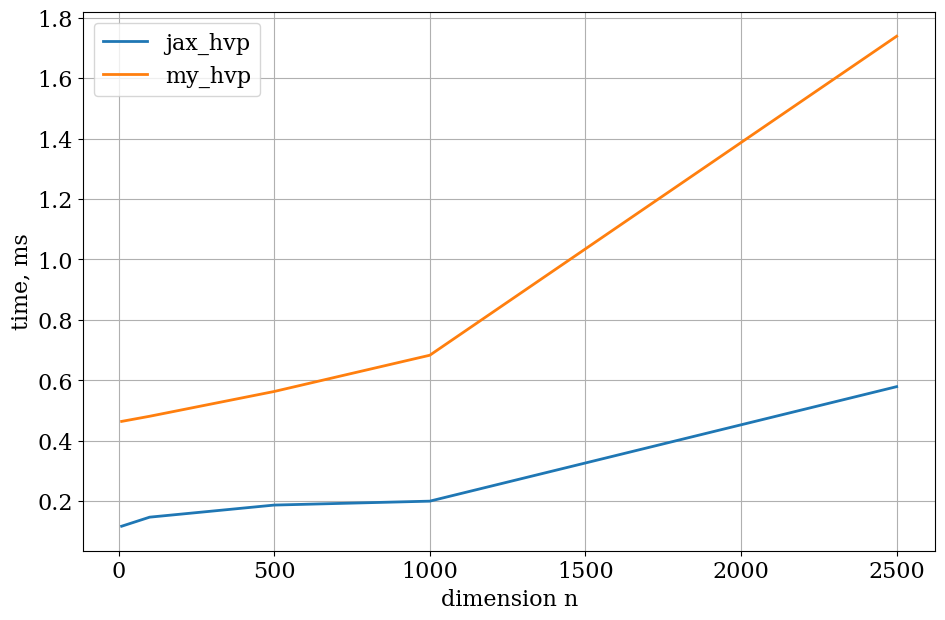

In [ ]:
plt.plot(ns, jax_hvp_times, label="jax_hvp")
plt.plot(ns, my_hvp_times, label="my_hvp")
plt.xlabel("dimension n")
plt.ylabel("time, ms")
plt.grid()
plt.legend()
plt.show()